In [1]:
import numpy as np
import pandas as pd 


from numpy import array
import torch
from torch import cat, no_grad, manual_seed
import gc
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

#Sklearn
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

manual_seed(444422)

In [2]:
df=pd.read_csv('../datos/perrin-freres-monthly-champagne.csv')
df=df.dropna()
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
...,...
1972-05-01,4618.0
1972-06-01,5312.0
1972-07-01,4298.0


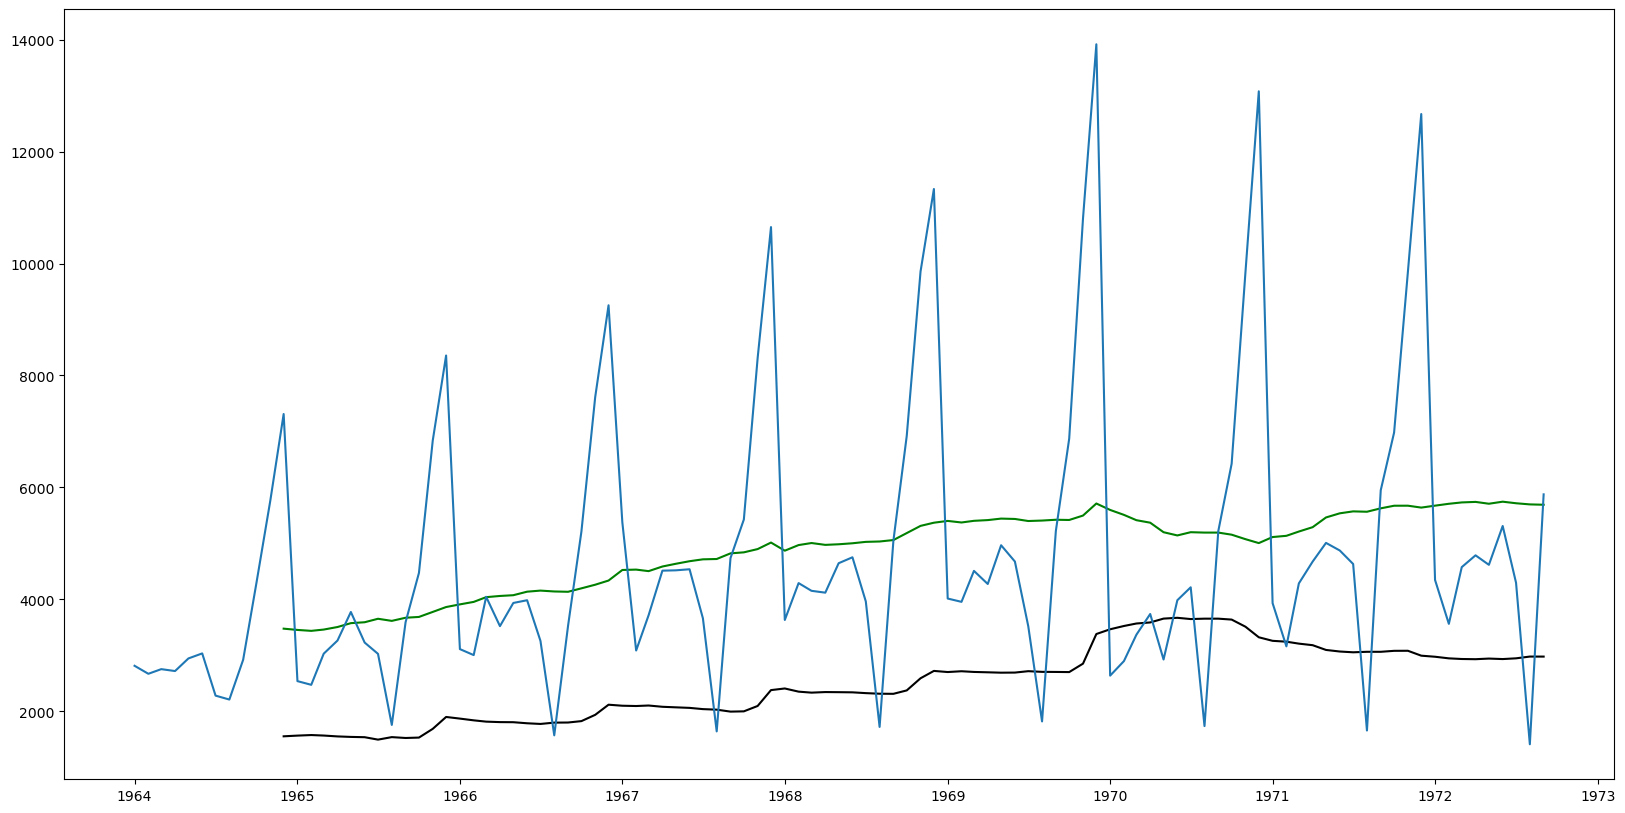

In [3]:
plt.figure(figsize=(20,10))
rolmean=df.rolling(window=12).mean()
rolstd=df.rolling(window=12).std()
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.plot(df, label='actual')
plt.show()

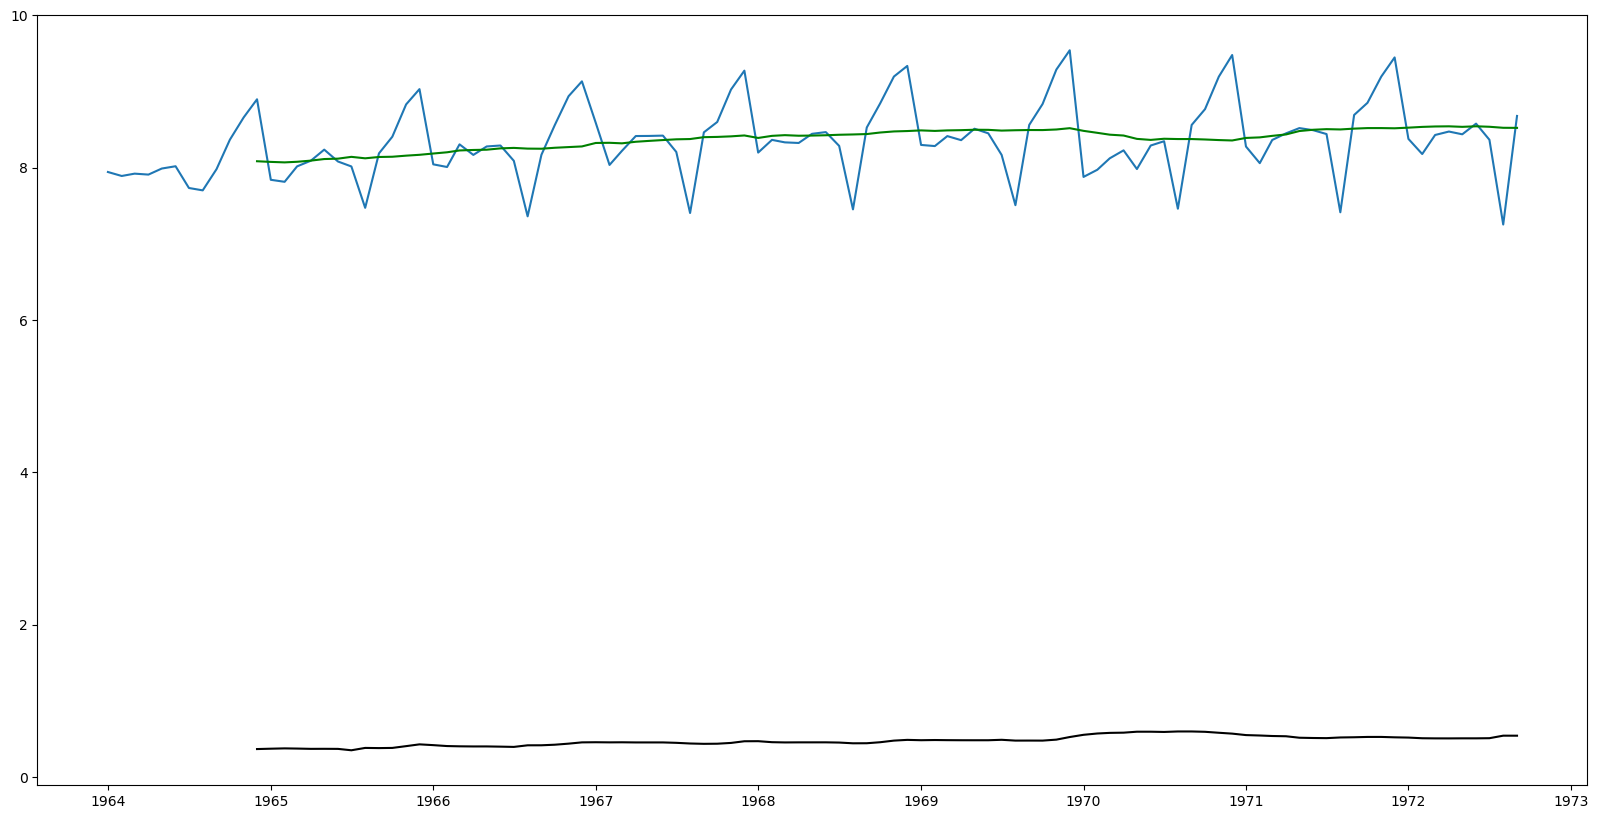

In [4]:
df_log=np.log(df)
MAvg=df_log.rolling(window=12).mean()
MStd=df_log.rolling(window=12).std()
plt.figure(figsize=(20,10))
plt.plot(df_log, label='Transformacion logaritmica')
plt.plot(MAvg, color='green', label='Rolling Mean') 
plt.plot(MStd, color='black', label='Rolling Std')

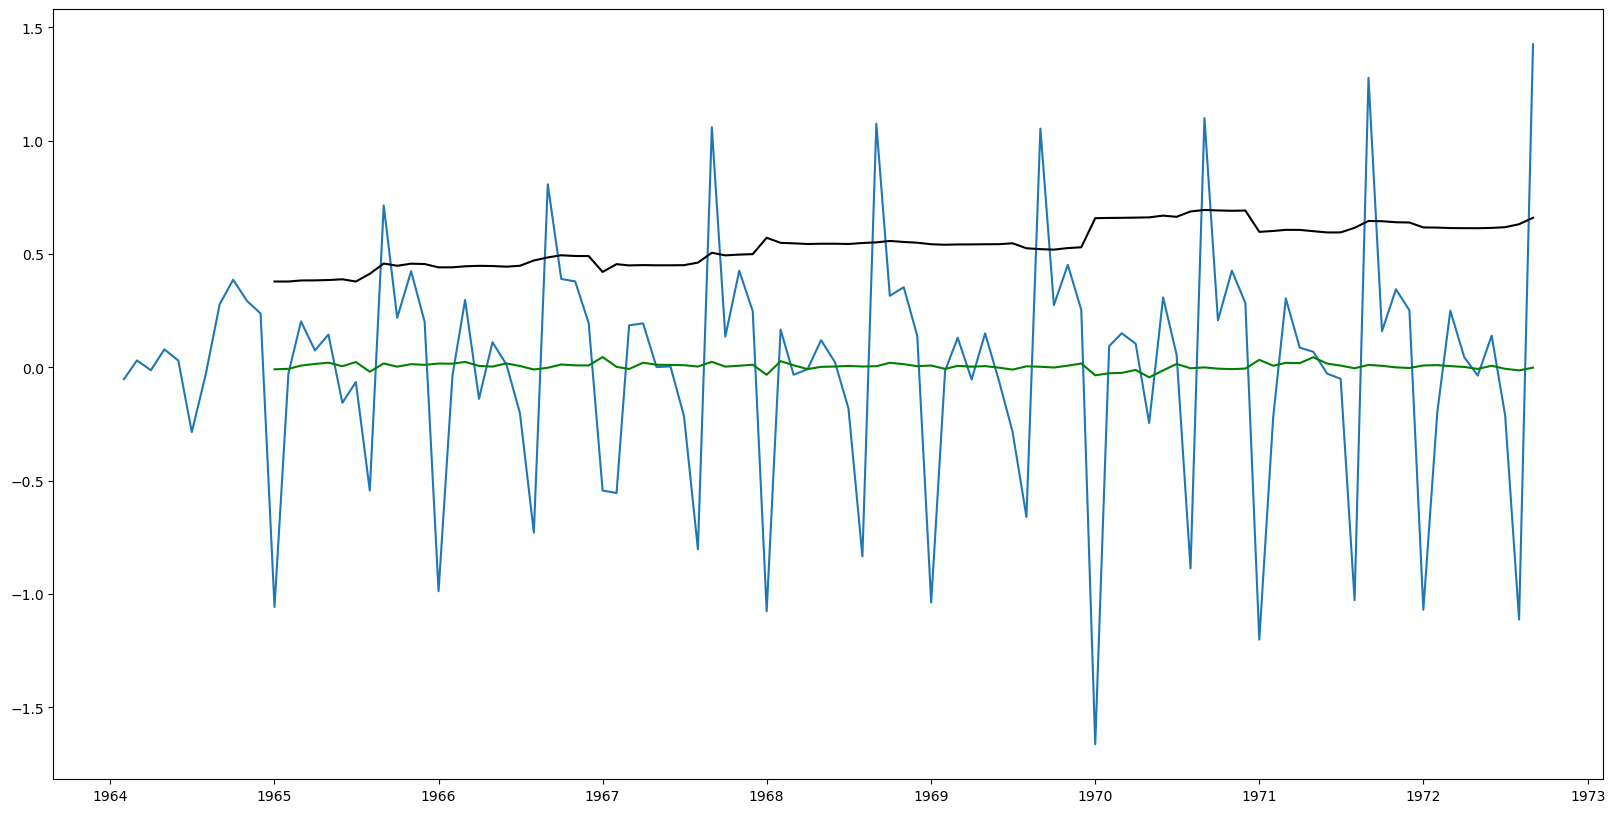

In [5]:
data_shift=df_log-df_log.shift()
plt.figure(figsize=(20,10))
MAvg=data_shift.rolling(window=12).mean()
MStd=data_shift.rolling(window=12).std()
plt.plot(data_shift, label='Transformacion logaritmica diferenciada')
plt.plot(MAvg, color='green', label='Rolling Mean') 
plt.plot(MStd, color='black', label='Rolling Std')
plt.show()

In [6]:
data_shift.dropna()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-02-01,-0.052135
1964-03-01,0.030590
1964-04-01,-0.012418
1964-05-01,0.079449
1964-06-01,0.030093
...,...
1972-05-01,-0.036151
1972-06-01,0.140007
1972-07-01,-0.211819


In [7]:
df=pd.read_csv('../datos/perrin-freres-monthly-champagne.csv')
df=df.dropna()
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])
df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift=data_shift.dropna()

In [8]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label
    
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.fc1 = nn.Linear(12,2)
        self.fc2 = nn.Linear(2,2)
        self.fc3 = nn.Linear(2,1)
        
    def forward(self,x):
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        
        return x
    
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        preds = torch.reshape(preds, (-1,))
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            preds = torch.reshape(preds, (-1,))
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        return valid_loss

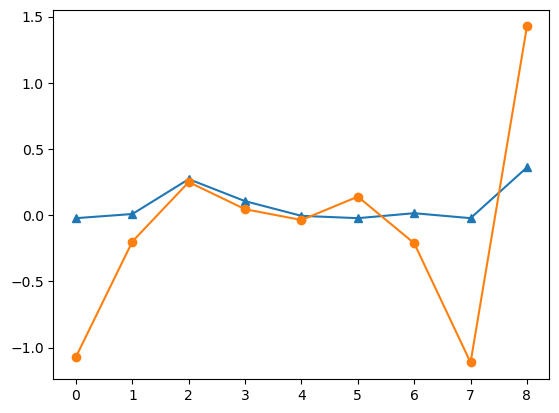

[3.5435843]


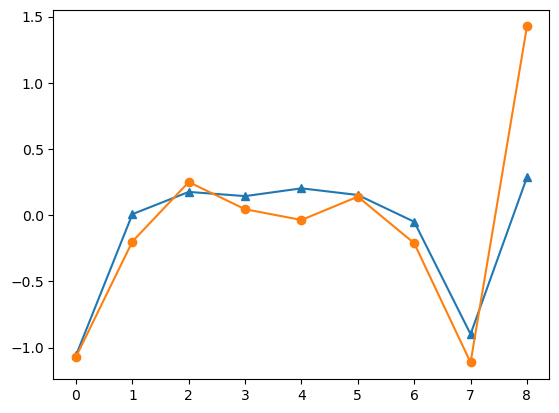

[1.4872941]


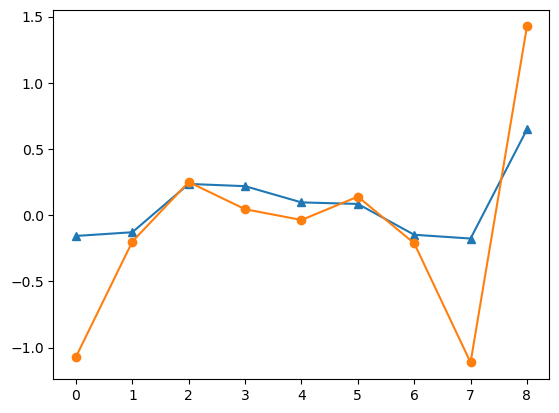

[2.3747795]


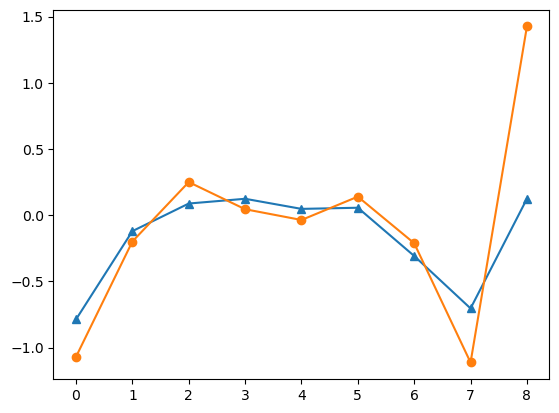

[2.0019917]


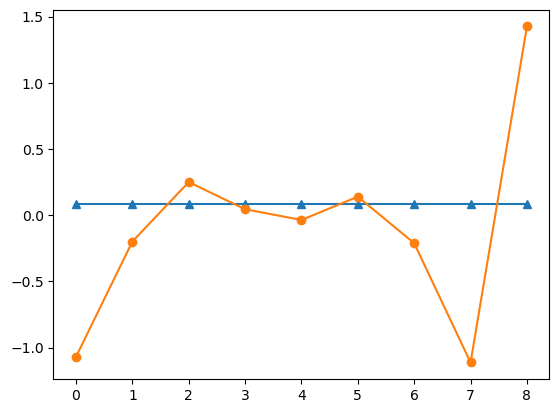

[4.772134]


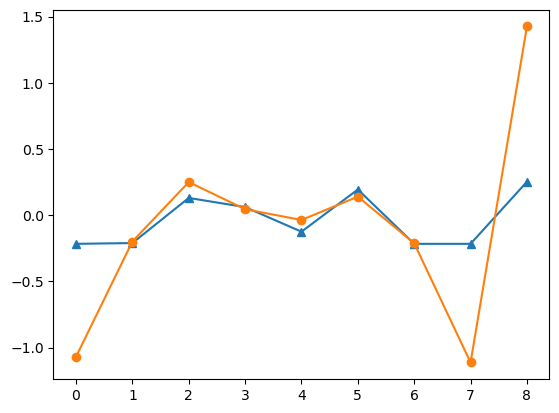

[2.9322214]


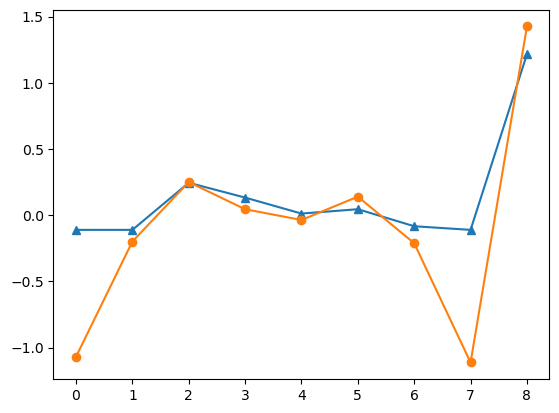

[2.0097268]


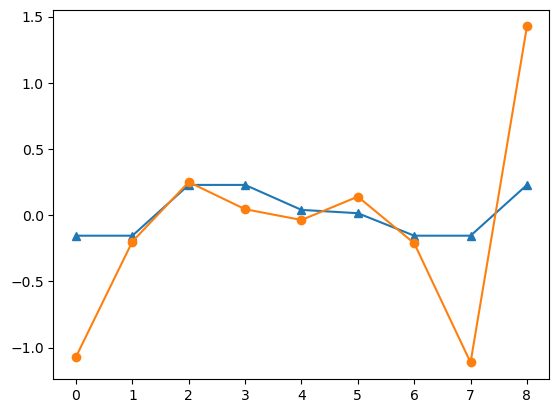

[3.2462583]


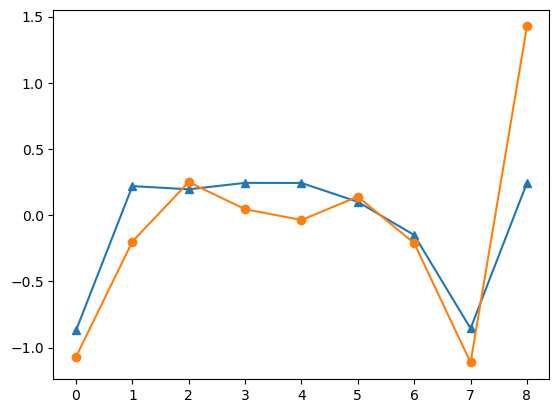

[1.8039427]


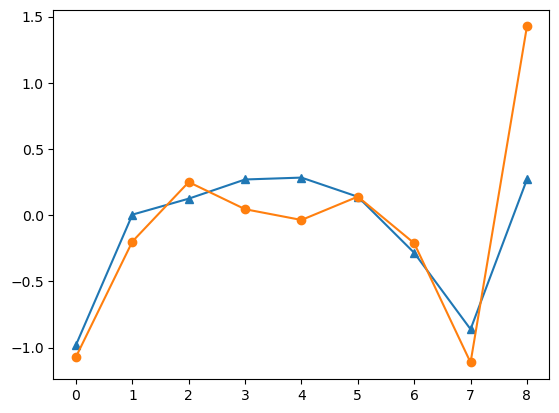

[1.6216955]


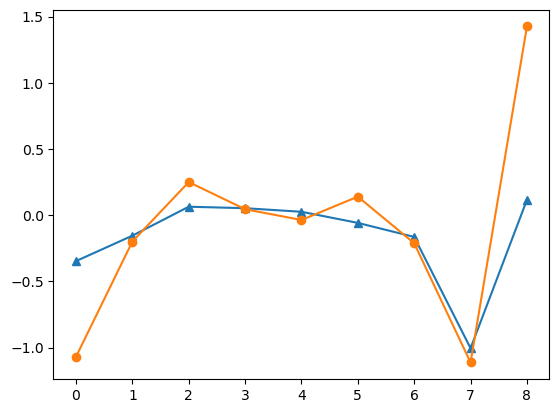

[2.3311265]


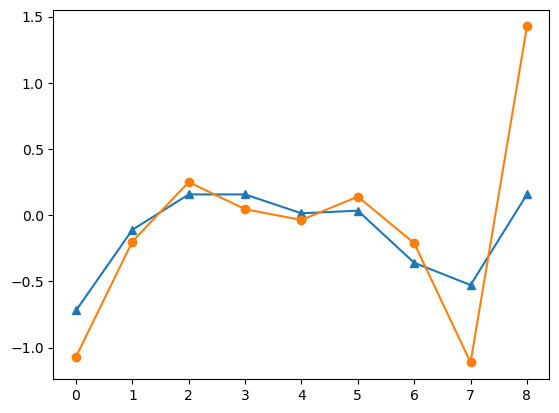

[2.1383078]


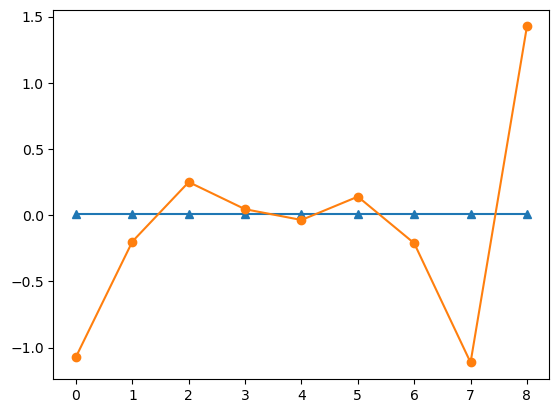

[4.594857]


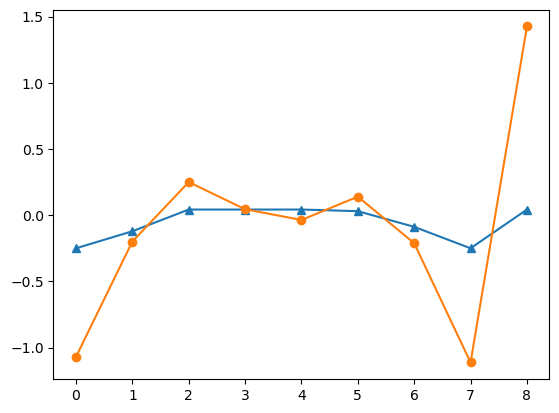

[3.4099097]


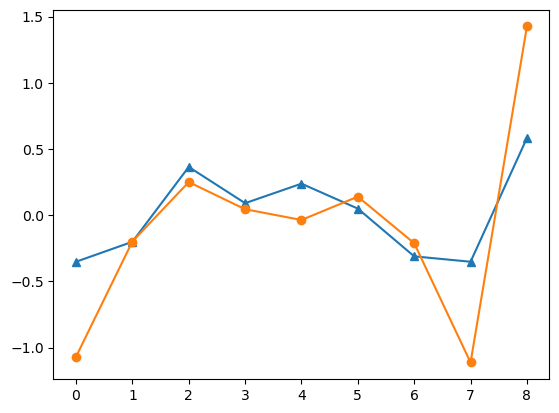

[1.9126861]


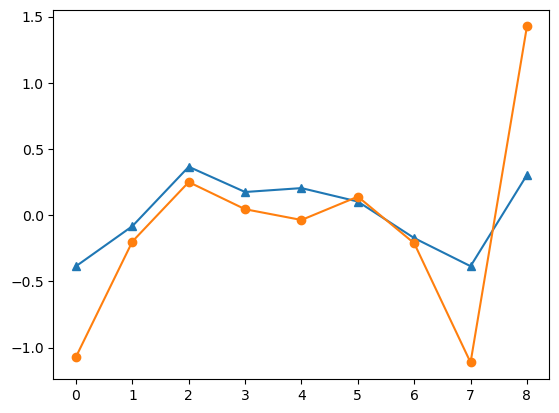

[2.3598256]


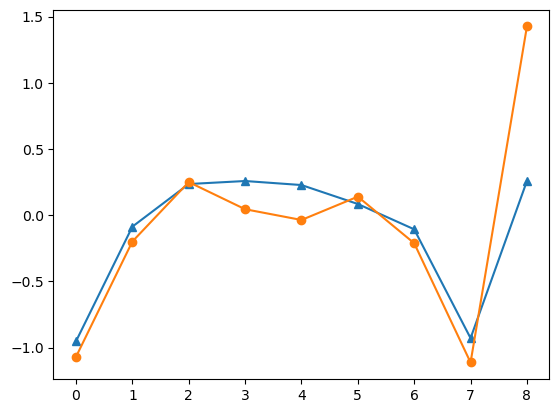

[1.551855]


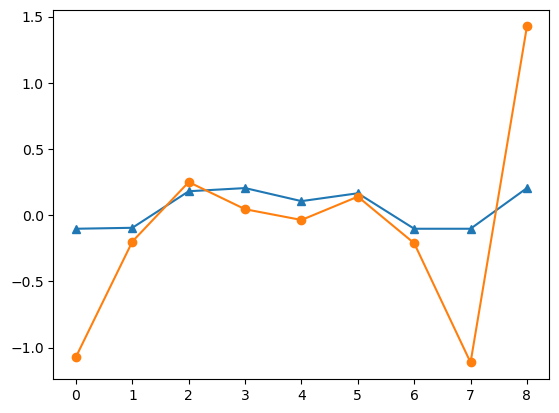

[3.519074]


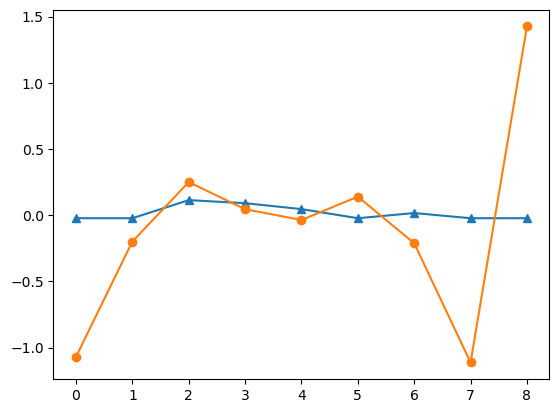

[4.5168104]


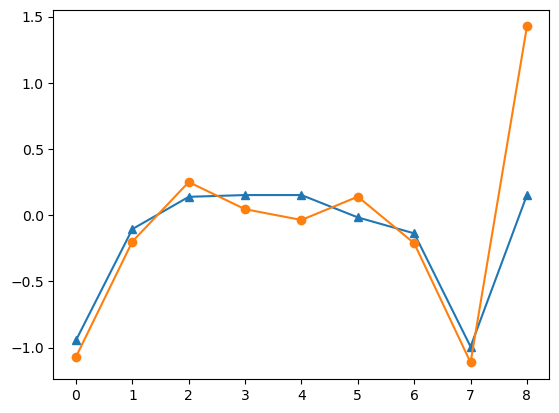

[1.7493134]


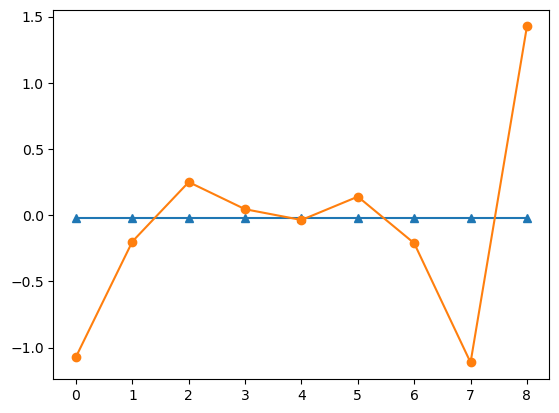

[4.556994]


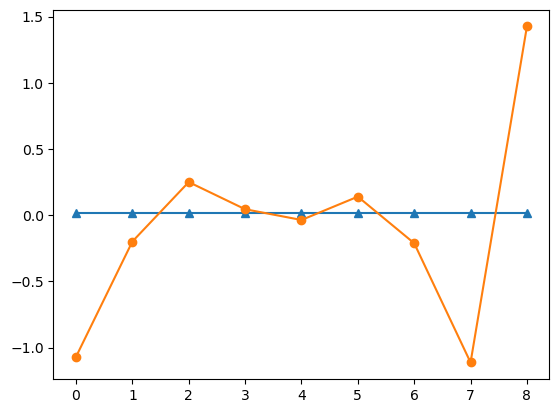

[4.615475]


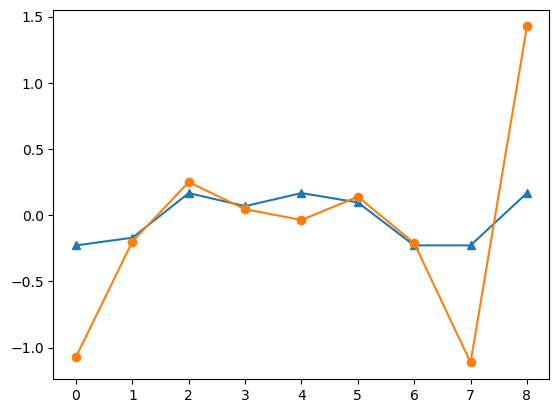

[3.124992]


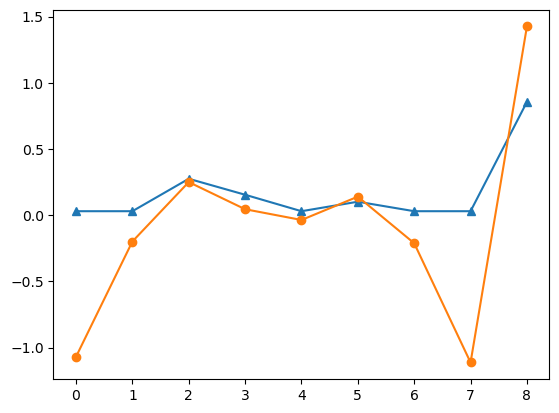

[2.9685445]


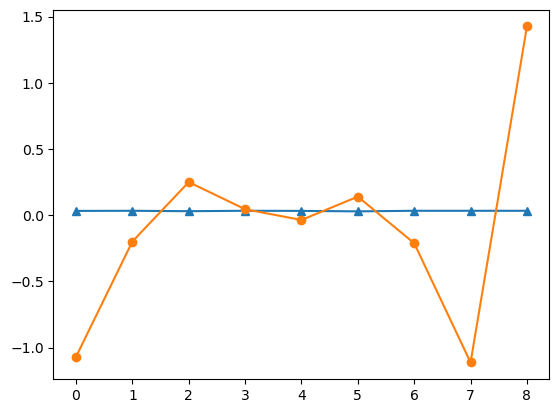

[4.644065]


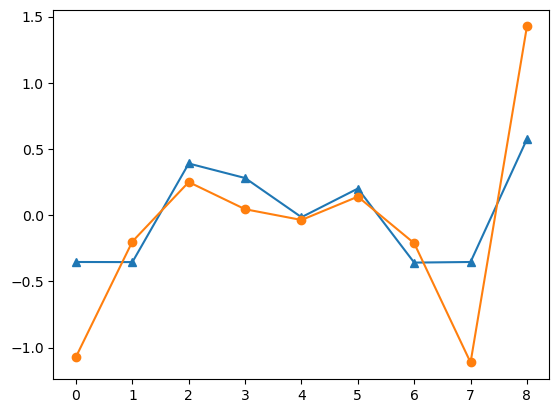

[1.9379714]


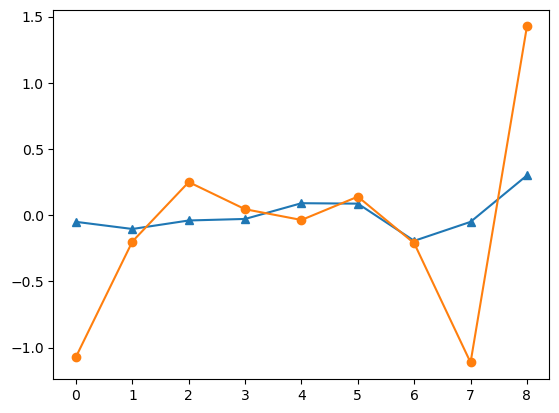

[3.5500565]


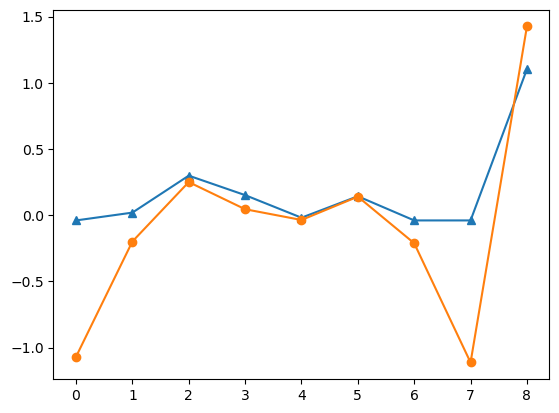

[2.407303]


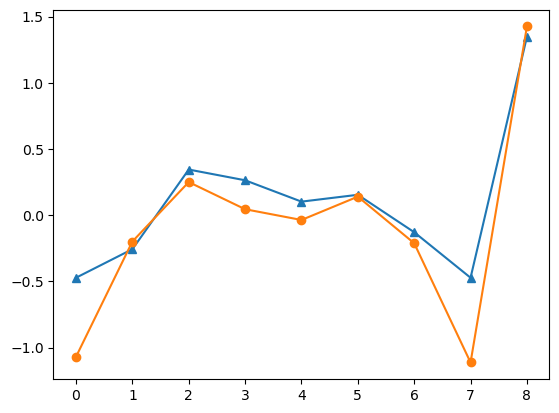

[0.85858184]


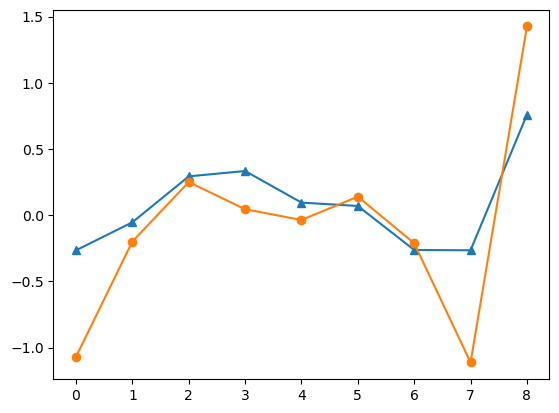

[1.9395175]


In [9]:
n_estadistico = 30
p_train = 0.8
n_steps = 12

train_losses = []
valid_losses = []
errores_cuadraticos_valid = []

for est in range(n_estadistico):
    
    # Partición de los datos
    train_set = data_shift.iloc[:int(len(data_shift)*0.8)]
    valid_set = data_shift.iloc[int(len(data_shift)*0.8):]
    
    
    train_x,train_y = split_sequence(np.array(train_set['Perrin Freres monthly champagne sales millions ?64-?72']),n_steps)
    valid_x,valid_y = split_sequence(np.array(valid_set['Perrin Freres monthly champagne sales millions ?64-?72']),n_steps)
    
    
    # Creación de los batches
    train = ElecDataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
    valid = ElecDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1),valid_y)
    train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)
    valid_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

    # Creacion del modelo
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = CNN_ForecastNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    
    # Entrenamiento del modelo
    epochs = 200
    for epoch in range(epochs):
        Train()
        loss_valid = Valid()
    
    model.eval()
    
    prediction = []
    inputs = valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1)
    
    batch_size = 1
    iterations =  int(inputs.shape[0]/batch_size)

    for i in range(iterations):
        preds = model(torch.tensor(inputs[batch_size*i:batch_size*(i+1)]).float())
        prediction.append(preds[0].detach().numpy())
    prediction = np.array(prediction)
    
    plt.plot(prediction, marker='^')
    plt.plot(valid_y, marker='o')
    plt.show()
    
    error_cuadratico = 0

    for i in range(len(prediction)):
        error_cuadratico = error_cuadratico + (prediction[i] - valid_y[i])**2
    error_cuadratico/len(prediction)
    
    errores_cuadraticos_valid.append(error_cuadratico)
    print(error_cuadratico)

In [10]:
errores_cuadraticos_valid = np.array(errores_cuadraticos_valid).reshape(len(errores_cuadraticos_valid))

print(errores_cuadraticos_valid)

[3.5435843  1.4872941  2.3747795  2.0019917  4.772134   2.9322214
 2.0097268  3.2462583  1.8039427  1.6216955  2.3311265  2.1383078
 4.594857   3.4099097  1.9126861  2.3598256  1.551855   3.519074
 4.5168104  1.7493134  4.556994   4.615475   3.124992   2.9685445
 4.644065   1.9379714  3.5500565  2.407303   0.85858184 1.9395175 ]
